In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

In [4]:
# Load the Breast Cancer Wisconsin dataset
url = '../data/wdbc.data'  # Path to your data file
columns = ['ID', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
data = pd.read_csv(url, header=None, names=columns)

In [5]:
# Preprocess the data: separate features and labels
X = data.drop(columns=["ID", "diagnosis"])  # Features
y = data["diagnosis"].map({'M': 1, 'B': 0})  # Labels: 1 for malignant, 0 for benign

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

In [6]:
# Separate the benign (negative) examples for training the autoencoder
X_benign = X_scaled[y == 0]  # Benign examples (normal data)
X_malignant = X_scaled[y == 1]  # Malignant examples (anomalies)

# Split benign data into train and test sets
X_train_benign, X_test_benign = train_test_split(X_benign, test_size=0.2, random_state=42)

# Split malignant data into train and test sets
X_train_malignant, X_test_malignant = train_test_split(X_malignant, test_size=0.2, random_state=42)


In [7]:
# Define and train the positive autoencoder on benign data
autoencoder_pos = MLPRegressor(hidden_layer_sizes=(14, 7, 14), activation='relu', max_iter=200, random_state=42)
autoencoder_pos.fit(X_train_benign, X_train_benign)

# Define and train the negative autoencoder on malignant data
autoencoder_neg = MLPRegressor(hidden_layer_sizes=(14, 7, 14), activation='relu', max_iter=200, random_state=42)
autoencoder_neg.fit(X_train_malignant, X_train_malignant)

/Users/bono/opt/miniconda3/envs/minenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/bono/opt/miniconda3/envs/minenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(14, 7, 14), random_state=42)

In [8]:
# Get reconstruction errors for benign and malignant examples using the postive autoencoder
X_test_pred_benign_pos = autoencoder_pos.predict(X_test_benign)
X_test_pred_malignant_pos = autoencoder_pos.predict(X_malignant) #testing all malignant examples for pos model

# Calculate reconstruction errors for the positive model
reconstruction_errors_benign_pos = np.mean((X_test_benign - X_test_pred_benign_pos) ** 2, axis=1)
reconstruction_errors_malignant_pos = np.mean((X_malignant - X_test_pred_malignant_pos) ** 2, axis=1)


In [9]:
# Get reconstruction errors for benign and malignant examples using the negative autoencoder
X_test_pred_benign_neg = autoencoder_neg.predict(X_benign) #testing all benign examples for neg model
X_test_pred_malignant_neg = autoencoder_neg.predict(X_test_malignant)

# Calculate reconstruction errors for the negative model
reconstruction_errors_benign_neg = np.mean((X_benign - X_test_pred_benign_neg) ** 2, axis=1)
reconstruction_errors_malignant_neg = np.mean((X_test_malignant - X_test_pred_malignant_neg) ** 2, axis=1)

In [11]:
#########fix me: this combined score may need fixing. we can only ensemble in the overlap.

# now create the combined reconstruction errors for positive and negative models
# the combined score is the pos score minus neg score divided by the sum of the two scores
# this is done to normalize the scores
#combined_reconstruction_errors = (reconstruction_errors_benign_pos - reconstruction_errors_benign_neg) / (reconstruction_errors_benign_pos + reconstruction_errors_benign_neg)


In [12]:
# Combine errors and labels for ROC curve calculation of positive model
errors_pos = np.concatenate([reconstruction_errors_benign_pos, reconstruction_errors_malignant_pos])
labels_pos = np.concatenate([np.zeros_like(reconstruction_errors_benign_pos), np.ones_like(reconstruction_errors_malignant_pos)])

# Combine errors and labels for ROC curve calculation of negative model
errors_neg = np.concatenate([reconstruction_errors_benign_neg, reconstruction_errors_malignant_neg])
labels_neg = np.concatenate([np.zeros_like(reconstruction_errors_benign_neg), np.ones_like(reconstruction_errors_malignant_neg)])

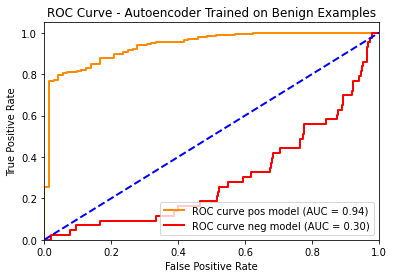

0.9394654088050315

In [14]:
# Calculate the ROC curve and AUC for positive model
fpr_pos, tpr_pos, thresholds = roc_curve(labels_pos, errors_pos)
roc_auc_pos = auc(fpr_pos, tpr_pos)

# Calculate the ROC curve and AUC for negative model
fpr_neg, tpr_neg, thresholds = roc_curve(labels_neg, errors_neg)
roc_auc_neg = auc(fpr_neg, tpr_neg)

# Plot the ROC curve
plt.figure()
#add the positive roc curve
plt.plot(fpr_pos, tpr_pos, color='darkorange', lw=2, label=f'ROC curve pos model (AUC = {roc_auc_pos:.2f})')
#add the negative roc curve 
plt.plot(fpr_neg, tpr_neg, color='red', lw=2, label=f'ROC curve neg model (AUC = {roc_auc_neg:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Autoencoder Trained on Benign Examples')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
roc_auc_pos